# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from numpy import random
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from IPython.display import display

In [3]:
# Hide all warnings

import warnings
warnings.filterwarnings('ignore')

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [4]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2199,0,28.0,29400.0,3,0
2880,1,27.0,37900.0,0,0
4972,1,25.0,29000.0,1,0
2611,0,20.0,42900.0,1,0
96,0,23.0,43700.0,0,0
2573,0,39.0,30000.0,3,0
2058,1,38.0,43500.0,0,0
4070,1,23.0,35800.0,3,0
2189,1,32.0,35500.0,0,0
3456,1,50.0,43300.0,1,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int')

In [9]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [11]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [12]:
df[df.duplicated()]

,gender,age,income,family_members,insurance_benefits
281,1,39,48100.0,1,0
488,1,24,32900.0,1,0
513,0,31,37400.0,2,0
718,1,22,32600.0,1,0
785,0,20,35800.0,0,0
...,...,...,...,...,...
4793,1,24,37800.0,0,0
4902,1,35,38700.0,1,0
4935,1,19,32700.0,0,0
4945,1,21,45800.0,0,0


In [13]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

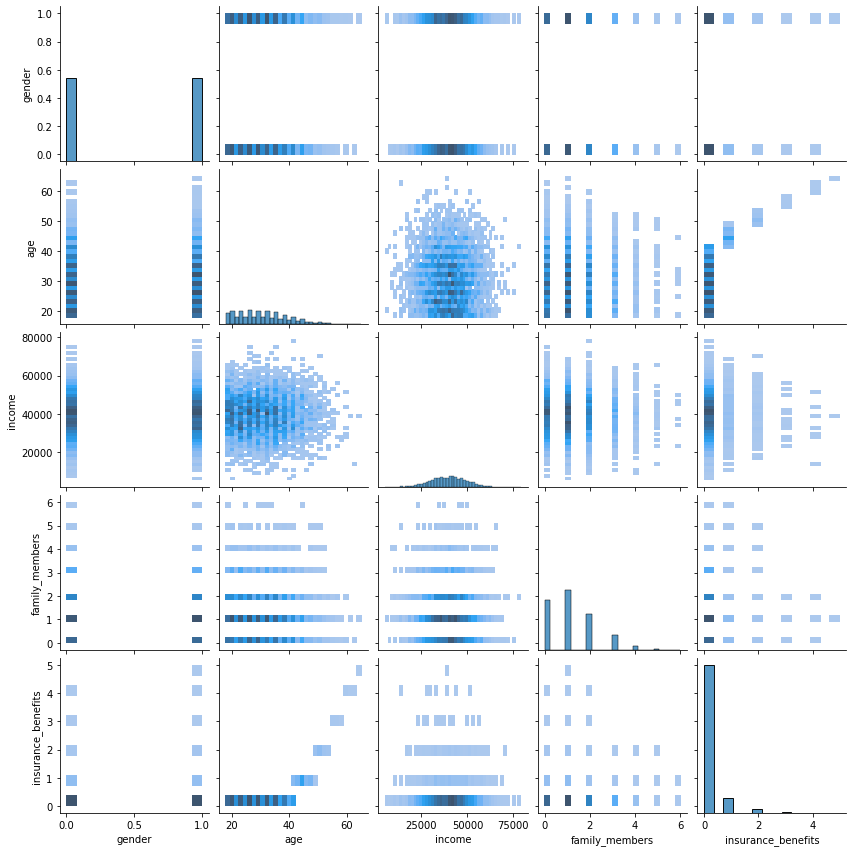

In [14]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    if metric == 'manhattan' or metric == "city block":
        nbrs = NearestNeighbors(n_neighbors=k, p=1)
    else:
        nbrs = NearestNeighbors(n_neighbors=k, p=2)
    nbrs.fit(df.drop('insurance_benefits', axis=1))
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
623,1.0,0.476923,0.411392,0.166667,0
1688,0.0,0.338462,0.644304,0.166667,0
2924,0.0,0.492308,0.600000,0.333333,0
1837,0.0,0.538462,0.426582,0.000000,0
3813,1.0,0.461538,0.508861,0.166667,0


Now, let's get similar records for a given one for every combination

In [19]:
get_knn(df, 3, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
3,0,21,41700.0,2,0,0.000000
2071,0,23,41700.0,0,0,2.828427
415,0,25,41700.0,2,0,4.000000
4723,1,26,41700.0,2,0,5.099020
4144,0,26,41700.0,0,0,5.385165


In [20]:
get_knn(df_scaled, 3, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
3,0.0,0.323077,0.527848,0.333333,0,0.000000
29,0.0,0.323077,0.534177,0.333333,0,0.006329
1594,0.0,0.323077,0.518987,0.333333,0,0.008861
3808,0.0,0.307692,0.525316,0.333333,0,0.015592
3326,0.0,0.307692,0.530380,0.333333,0,0.015592


In [21]:
get_knn(df, 3, 5, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
3,0,21,41700.0,2,0,0.0
415,0,25,41700.0,2,0,4.0
2071,0,23,41700.0,0,0,4.0
4723,1,26,41700.0,2,0,6.0
4144,0,26,41700.0,0,0,7.0


In [22]:
get_knn(df_scaled, 3, 5, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
3,0.0,0.323077,0.527848,0.333333,0,0.000000
29,0.0,0.323077,0.534177,0.333333,0,0.006329
1594,0.0,0.323077,0.518987,0.333333,0,0.008861
3808,0.0,0.307692,0.525316,0.333333,0,0.017916
3326,0.0,0.307692,0.530380,0.333333,0,0.017916


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the data being scaled does affet the kNN algorithm. This can be observed by looking at the indexes of the nearest neighbors that were returned. The indices of the nearest neighbors for the non-scaled data are **3**, **415**, **2071**, **4723**, and **4144**. The indices of the nearest neighbors for the scaled data are **3**, **29**, **1594**, **3808**, and **3326**.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Results using the Manhattan distance metric are identcial the results using the Euclidean distance metric.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

To be more specific about what makes the results on scaled and unscaled data different let's look at the top neighbors on unscaled data. Notice how all of them have exactly the same income. Now the important point is that with unscaled data if some feature (like income) has a much bigger magnitude than others, then in the distance calculation it has much more weight, and the other features are basically disregarded. Scaling makes all features measured on the same scale.

</div>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [23]:
# calculate the target

from sklearn.neighbors import KNeighborsClassifier

def calculate_target(df):
    ''''''
    df.loc[df['insurance_benefits'] > 0, 'insurance_benefits_received'] = 1
    df.loc[df['insurance_benefits'] == 0, 'insurance_benefits_received'] = 0
        
calculate_target(df)
calculate_target(df_scaled)
       

In [24]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0.0    4284
1.0     563
Name: insurance_benefits_received, dtype: int64

In [25]:
# check for the class imbalance with value_counts()

df_scaled['insurance_benefits_received'].value_counts()

0.0    4284
1.0     563
Name: insurance_benefits_received, dtype: int64

Yes, there is significant class imbalance. There are only **563** positive targets compared to the **4,284** negative targets.

In [26]:
# split the data into 70:30 training and testing

# Non-scaled data
features = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target = df['insurance_benefits_received']

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=12345)

# Scaled data
features_scaled = df_scaled.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target_scaled = df_scaled['insurance_benefits_received']
train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled = train_test_split(features_scaled, target_scaled, test_size=0.3, random_state=12345)


In [27]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [28]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

### Euclidean method on non-scaled data

In [29]:
# Train kNN classifier for various k values, calculate F1 score
# Non-scaled data
for k in range(1, 11):
    neigh = KNeighborsClassifier(n_neighbors=k, p=2)
    neigh.fit(train_features, train_target)
    predictions = neigh.predict(test_features)
    eval_classifier(test_target, predictions)
    

F1: 0.68
Confusion Matrix
[[0.86254296 0.02199313]
 [0.04536082 0.07010309]]
F1: 0.38
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.08728522 0.02817869]]
F1: 0.38
Confusion Matrix
[[0.87147766 0.01305842]
 [0.08522337 0.03024055]]
F1: 0.18
Confusion Matrix
[[0.8790378  0.00549828]
 [0.10378007 0.01168385]]
F1: 0.23
Confusion Matrix
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]
F1: 0.06
Confusion Matrix
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]
F1: 0.07
Confusion Matrix
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]


### Euclidean method on scaled data

In [30]:
# Train kNN classifier for various k values, calculate F1 score
# Scaled data
for k in range(1, 11):
    neigh = KNeighborsClassifier(n_neighbors=k, p=2)
    neigh.fit(train_features_scaled, train_target_scaled)
    predictions = neigh.predict(test_features_scaled)
    eval_classifier(test_target_scaled, predictions)

F1: 0.93
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01168385 0.10378007]]
F1: 0.89
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02199313 0.09347079]]
F1: 0.91
Confusion Matrix
[[0.88041237 0.00412371]
 [0.01649485 0.09896907]]
F1: 0.88
Confusion Matrix
[[0.88178694 0.00274914]
 [0.0233677  0.09209622]]
F1: 0.89
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.0185567  0.09690722]]
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]
F1: 0.90
Confusion Matrix
[[0.88178694 0.00274914]
 [0.01924399 0.09621993]]
F1: 0.86
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]
F1: 0.86
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]


### Manhattan method on non-scaled data

In [31]:
# Train kNN classifier for various k values, calculate F1 score
# Non-scaled data
for k in range(1, 11):
    neigh = KNeighborsClassifier(n_neighbors=k, p=1)
    neigh.fit(train_features, train_target)
    predictions = neigh.predict(test_features)
    eval_classifier(test_target, predictions)

F1: 0.67
Confusion Matrix
[[0.86185567 0.02268041]
 [0.04604811 0.06941581]]
F1: 0.39
Confusion Matrix
[[0.88041237 0.00412371]
 [0.08659794 0.02886598]]
F1: 0.40
Confusion Matrix
[[0.87353952 0.01099656]
 [0.0838488  0.03161512]]
F1: 0.19
Confusion Matrix
[[0.8790378  0.00549828]
 [0.10309278 0.01237113]]
F1: 0.23
Confusion Matrix
[[0.87697595 0.00756014]
 [0.09965636 0.01580756]]
F1: 0.06
Confusion Matrix
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]
F1: 0.07
Confusion Matrix
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]


### Manhattan method on scaled data

In [32]:
# Train kNN classifier for various k values, calculate F1 score
# Scaled data
for k in range(1, 11):
    neigh = KNeighborsClassifier(n_neighbors=k, p=1)
    neigh.fit(train_features_scaled, train_target_scaled)
    predictions = neigh.predict(test_features_scaled)
    eval_classifier(test_target_scaled, predictions)

F1: 0.92
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01237113 0.10309278]]
F1: 0.89
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02061856 0.09484536]]
F1: 0.93
Confusion Matrix
[[0.88178694 0.00274914]
 [0.01305842 0.1024055 ]]
F1: 0.88
Confusion Matrix
[[0.88316151 0.00137457]
 [0.02405498 0.09140893]]
F1: 0.90
Confusion Matrix
[[0.88109966 0.00343643]
 [0.0185567  0.09690722]]
F1: 0.87
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02474227 0.09072165]]
F1: 0.89
Confusion Matrix
[[0.88109966 0.00343643]
 [0.01924399 0.09621993]]
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02474227 0.09072165]]
F1: 0.88
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02199313 0.09347079]]
F1: 0.87
Confusion Matrix
[[0.88316151 0.00137457]
 [0.02542955 0.09003436]]


In [33]:

for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))

    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



### Conclusions summary

When utilizng non-scaled data, it appears that as you add more neighbors that they F1 score begins to decrease, rather quickly. All four of the KNeighborClassifier instances start off much better than the dummy model, but as more neighbors were added, the F1 score for models using non-scaled data fell inline with the dummy model with a score of **0**. The best results were obtained when using the scaled data. The best F1 score was **93** when either the Euclidean or Manhattan method was only using 1 neighbor with the scaled data.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [34]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = ((np.linalg.inv(X2.T.dot(X2))).dot(X2.T)).dot(y)
        self.w = self.weights[1:]
        self.w0 = self.weights[0]

    def predict(self, X):
        y_pred = X.dot(self.w) + self.w0
        
        return y_pred

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


In [37]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736673  2.32727489  0.01955949  0.04624156 -0.07297105]
RMSE: 0.36
R2: 0.66


The RMSE and R2 are equivalent for both the model trained with non-scaled data and the model trained with scaled data. A difference between the two models is not observed.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [40]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [41]:
try:
    P_inverse = np.linalg.inv(P)
    print('The matrix P is invertible')
except:
    print('The matrix P is non-invertible')

The matrix P is invertible


Can you guess the customers' ages or income after the transformation?

No, I cannot determine the customers' ages or income after the tranformation. The numbers presented are incredibly large, and cannot be used to determine any personal info about the customers.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

Original Data:

In [42]:
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Transformed Data:

In [43]:
# multiply x by P
X_obfuscated = X.dot(P)

In [44]:
X_obfuscated

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

The reversed (recovered) one

In [45]:
X_obfuscated.dot(np.linalg.inv(P))

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Due to the way Python executes certain arithmetic some numbers do not come out to a perfect zero. Instead they are just returned as a very, very small number. But, for all intensive purposes the very, very small numbers can be viewed as being equivalent to zero.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$$w_P = P^{-1}w$$

**Analytical proof**

Initial formula:


$$w_P = [(XP)^{T}XP]^{-1}(XP)^{T}y$$


Reverse transpose:


$$w_P = [(X^{T}P^{T})XP]^{-1}(X^{T}P^{T})y$$


Rearrange using associative property:


$$w_P = [(X^{T}X)P^{T}P]^{-1}(X^{T}P^{T})y$$


Apply properties of inverse matrices:


$$w_P = (X^{T}X)^{-1}(P^{T})^{-1}P^{-1}X^{T}P^{T}y$$


Rearrange:


$$w_P = (X^{T}X)^{-1}P^{T}(P^{T})^{-1}P^{-1}X^{T}y$$


Apply properties of inverse matrices:


$$w_P = (X^{T}X)^{-1}P^{-1}X^{T}y$$


Rearrange:


$$w_P = P^{-1}(X^T X)^{-1} X^T y$$


Substitute $w$ in:


$$w_P = P^{-1}w$$

The predicted values and RMSE will be the same using $w$ or $w_p$.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [46]:
class MyObfuscatedLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y, obfuscated=False):
        self.obfuscated = obfuscated
        if self.obfuscated == True:
            print('obfuscated')
            X2 = np.append(np.ones([len(X), 1]), X, axis=1)
            self.P = self.check_for_inverse(X2)
            self.weights = ((np.linalg.inv(((X2.dot(self.P)).T).dot(X2.dot(self.P)))).dot((X2.dot(self.P)).T)).dot(y)
  
        else:
            print('Not obfuscated')
            X2 = np.append(np.ones([len(X), 1]), X, axis=1)
            self.weights = ((np.linalg.inv(X2.T.dot(X2))).dot(X2.T)).dot(y)

    def predict(self, X):
        if self.obfuscated == True:
            X2 = np.append(np.ones([len(X), 1]), X, axis=1)
            y_pred = (X2.dot(self.P)).dot(self.weights)
        else:
            X2 = np.append(np.ones([len(X), 1]), X, axis=1)
            y_pred = X2.dot(self.weights)
        
        return y_pred
    
    def check_for_inverse(self, X):
        #initialize random generator
        rng = np.random.default_rng(seed=42)
        
        while True:
            P = rng.random(size=(X.shape[1], X.shape[1]))
            try:
                np.linalg.inv(P)
                print("The matrix, P, is invertible.")
                return P
            except:
                continue
        

In [47]:
# Regular
molr = MyObfuscatedLinearRegression()
molr

molr.fit(X_train, y_train)
print(molr.weights)

y_test_pred = molr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Not obfuscated
[-0.97736673  2.32727489  0.01955949  0.04624156 -0.07297105]
RMSE: 0.36
R2: 0.66


In [48]:
# Obfuscated
molr = MyObfuscatedLinearRegression()

molr.fit(X_train, y_train, obfuscated=True)
print(molr.weights)

y_test_pred = molr.predict(X_test)
eval_regressor(y_test, y_test_pred)

obfuscated
The matrix, P, is invertible.
[ 0.81359993  1.52880978 -0.45081985 -3.04570839  2.47441331]
RMSE: 0.36
R2: 0.66


As can be seen, the RMSE and R2 score using non-obfuscated data and obfuscated data are the same. There is no difference between the two methods.

# Conclusions

Throughout this project we have learned quite a bit about kNN models, the Euclidean method, the Manhattan method, Linear Regression, and obfuscation. We first examined how KNeighborsClassifier models differed depending on if they were passed scaled or non-scaled data and how many k neighbors the models were to use. It was quickly seen that training models with scaled data outputed better results. We then tested Linear Regression on both the scaled and non-scaled datasets. No differences were seen between the RMSE and R2 values for either model. Finally, we tested whether or not we would obtain the same predictions after performing obfuscation on the original dataset. It was observed that the RMSE and R2 values were the same after obfuscation as they were before obfuscation. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear regression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>